 - Setting up a test harness
 - Generating strong baseline forecasts
 - Assessing the forecastability of a time series


## Creating holdout (test) and validation datasets

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from statsforecast import StatsForecast


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


<Axes: >

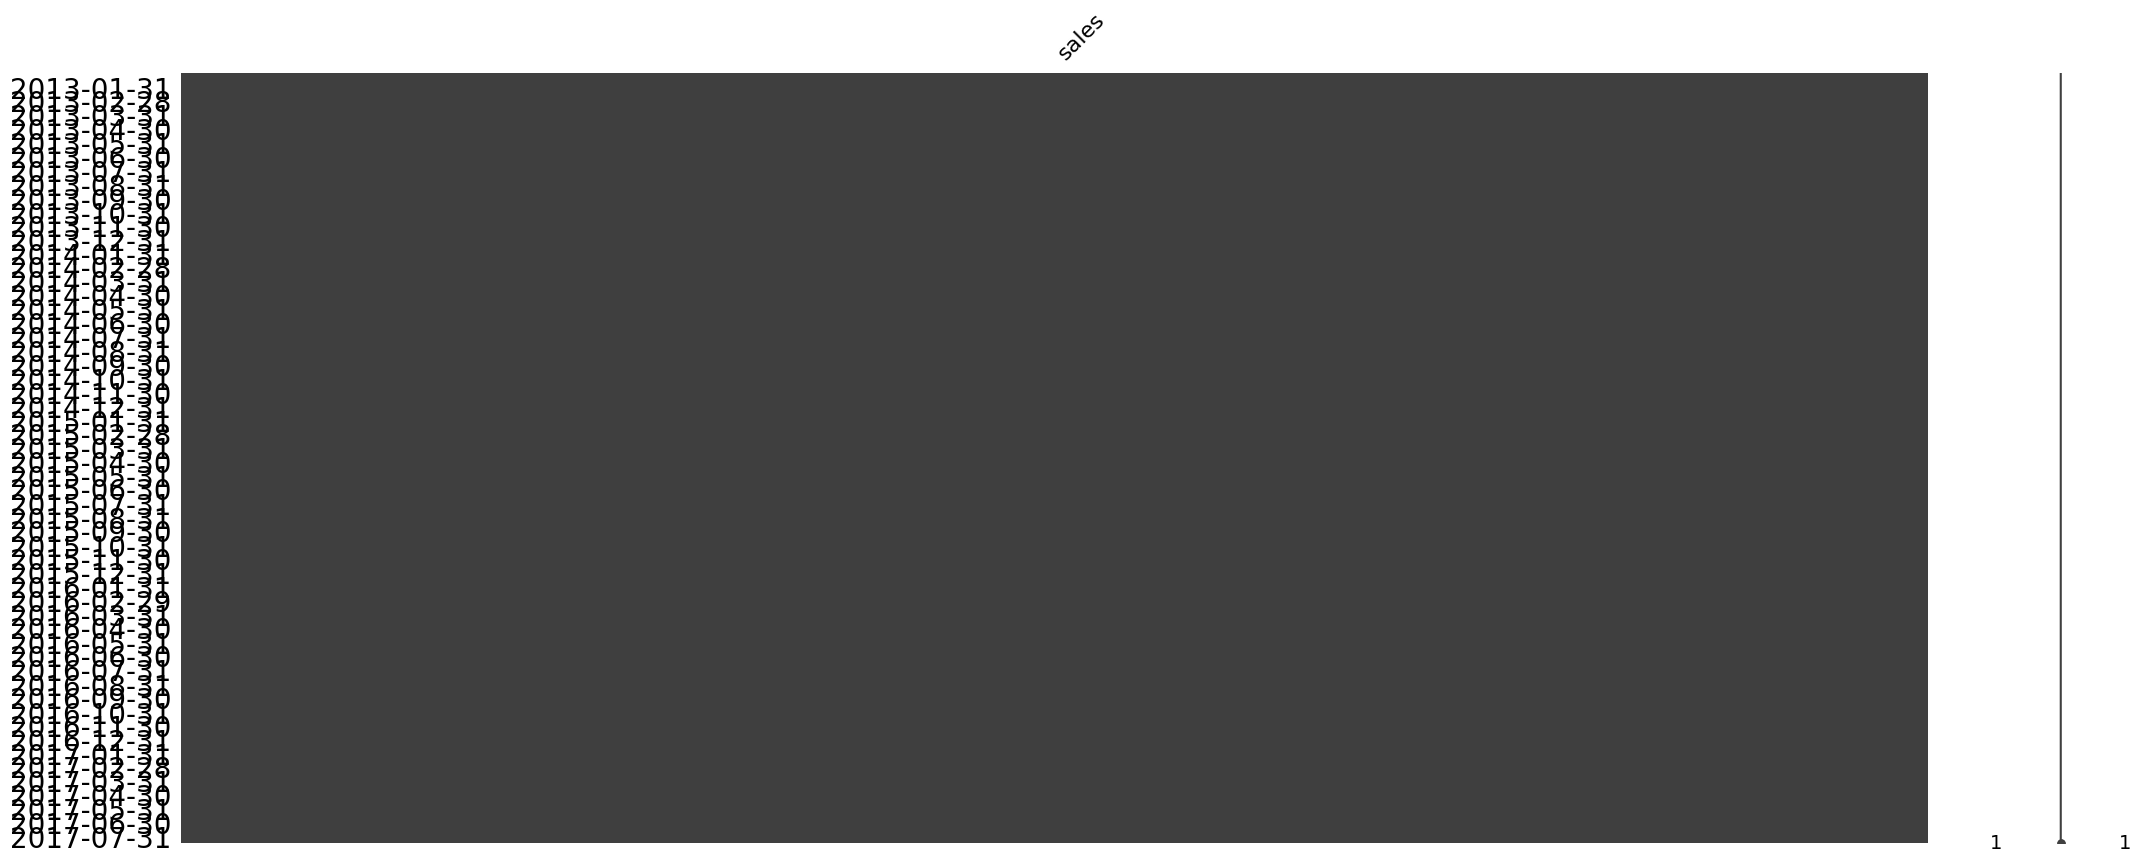

In [90]:
dir='data/store-sales-time-series-forecasting'
file='train.csv'
df=pd.read_csv(f'{dir}/{file}')
df.date=pd.to_datetime(df.date)

store_nbr=list(df.store_nbr.unique())[1]
df_store_nbr=df[df['store_nbr']==store_nbr]
family=list(df_store_nbr.family.unique())[0]
df_store_nbr_family=df_store_nbr[df_store_nbr['family']==family]
df_store_nbr_family=df_store_nbr_family.set_index('date')
msno.matrix(df_store_nbr_family[['sales']], freq="M")

In [91]:
df_store_nbr_family

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,33,10,AUTOMOTIVE,0.0,0
2013-01-02,1815,10,AUTOMOTIVE,3.0,0
2013-01-03,3597,10,AUTOMOTIVE,2.0,0
2013-01-04,5379,10,AUTOMOTIVE,2.0,0
2013-01-05,7161,10,AUTOMOTIVE,0.0,0
...,...,...,...,...,...
2017-08-11,2992011,10,AUTOMOTIVE,2.0,0
2017-08-12,2993793,10,AUTOMOTIVE,2.0,0
2017-08-13,2995575,10,AUTOMOTIVE,0.0,0


In [92]:
# Get year-month for each row
year_month = df_store_nbr_family.index.to_period('M')

# Identify last and second-last month
last_month = year_month.max()
val_month = last_month - 1

print(last_month,val_month)

2017-08 2017-07


In [93]:
# Test set → last month
ts_test = df_store_nbr_family.loc[year_month == last_month, ['sales']]

# Validation set → second last month
ts_val = df_store_nbr_family.loc[year_month == val_month, ['sales']]

# Train set → everything before validation month
ts_train = df_store_nbr_family.loc[year_month < val_month, ['sales']]

print(ts_train.shape,ts_val.shape,ts_test.shape)

(1638, 1) (31, 1) (15, 1)


In [94]:
print(ts_train.index.min(), "→", ts_train.index.max())
print(ts_val.index.min(), "→", ts_val.index.max())
print(ts_test.index.min(), "→", ts_test.index.max())

2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


In [95]:
_ts_train = (
    ts_train
    .reset_index()
    .rename(columns={
        'date': 'ds',
        'sales': 'y'
    })
)

_ts_train['unique_id'] = f'store_{store_nbr}_{family}'


_ts_val = (
    ts_val
    .reset_index()
    .rename(columns={
        'date': 'ds',
        'sales': 'y'
    })
)

_ts_val['unique_id'] = f'store_{store_nbr}_{family}'

MAE: 2.774
RMSE: 3.069
MASE: 1.094


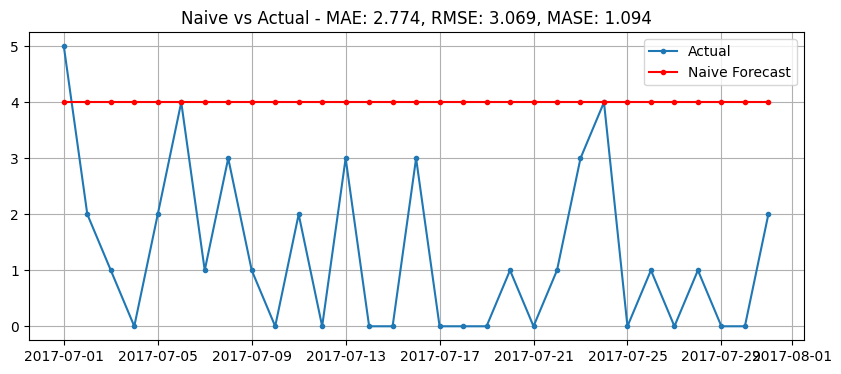

In [96]:
from statsforecast import StatsForecast
from statsforecast.models import Naive

models = [Naive()]
key='Naive'

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
    fallback_model=Naive()
)

h = len(ts_val)

y_pred = sf.forecast(
    df=_ts_train,
    h=h,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

results = _ts_val.merge(
    y_pred,
    on=['unique_id', 'ds'],
    how='left'
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = results['y'].values
y_hat = results[key].values

mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / scale

mase_value = mase(
    y_true,
    y_hat,
    ts_train['sales'].values,
    seasonality=7
)

print(f"MASE: {mase_value:.3f}")

plt.figure(figsize=(10, 4))

plt.plot(results['ds'], results['y'], '.-',label='Actual')
plt.plot(results['ds'], results[key],'.-', label=f'{key} Forecast', color='red')

plt.title(f'{key} vs Actual - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MASE: {mase_value:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### Seasonal Naive forecast

MAE: 1.806
RMSE: 2.200
MASE: 0.712


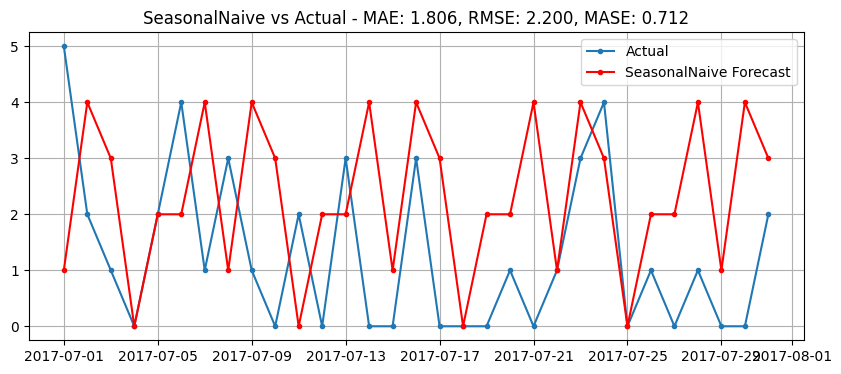

In [97]:
from statsforecast.models import SeasonalNaive
seasonal_naive = SeasonalNaive(season_length=7)
key='SeasonalNaive'
models = [seasonal_naive]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
    fallback_model=Naive()
)

h = len(ts_val)

y_pred = sf.forecast(
    df=_ts_train,
    h=h,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

results = _ts_val.merge(
    y_pred,
    on=['unique_id', 'ds'],
    how='left'
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = results['y'].values
y_hat = results[key].values

mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / scale

mase_value = mase(
    y_true,
    y_hat,
    ts_train['sales'].values,
    seasonality=7
)

print(f"MASE: {mase_value:.3f}")

plt.figure(figsize=(10, 4))

plt.plot(results['ds'], results['y'], '.-',label='Actual')
plt.plot(results['ds'], results[key],'.-', label=f'{key} Forecast', color='red')

plt.title(f'{key} vs Actual - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MASE: {mase_value:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### Exponential smoothing

MAE: 2.036
RMSE: 2.301
MASE: 0.803


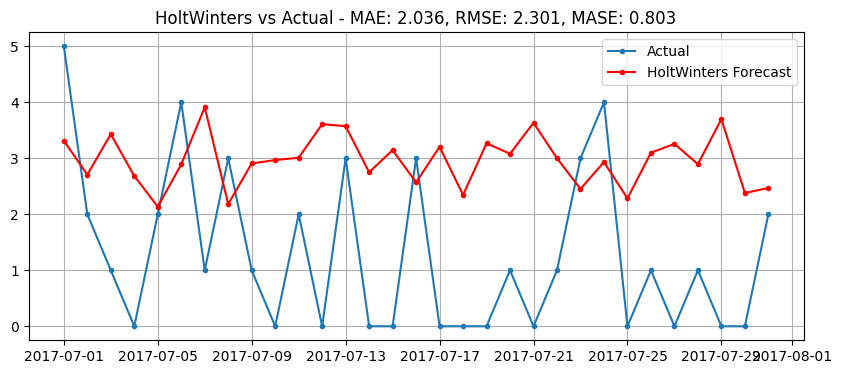

In [98]:
from statsforecast.models import (SimpleExponentialSmoothing, Holt, HoltWinters, AutoETS)
exp_smooth = HoltWinters(error_type = 'A', season_length = 48)

key='HoltWinters'
models = [exp_smooth]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
    fallback_model=Naive()
)

h = len(ts_val)

y_pred = sf.forecast(
    df=_ts_train,
    h=h,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

results = _ts_val.merge(
    y_pred,
    on=['unique_id', 'ds'],
    how='left'
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = results['y'].values
y_hat = results[key].values

mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / scale

mase_value = mase(
    y_true,
    y_hat,
    ts_train['sales'].values,
    seasonality=7
)

print(f"MASE: {mase_value:.3f}")

plt.figure(figsize=(10, 4))

plt.plot(results['ds'], results['y'], '.-',label='Actual')
plt.plot(results['ds'], results[key],'.-', label=f'{key} Forecast', color='red')

plt.title(f'{key} vs Actual - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MASE: {mase_value:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### AutoARIMA

MAE: 1.997
RMSE: 2.225
MASE: 0.787


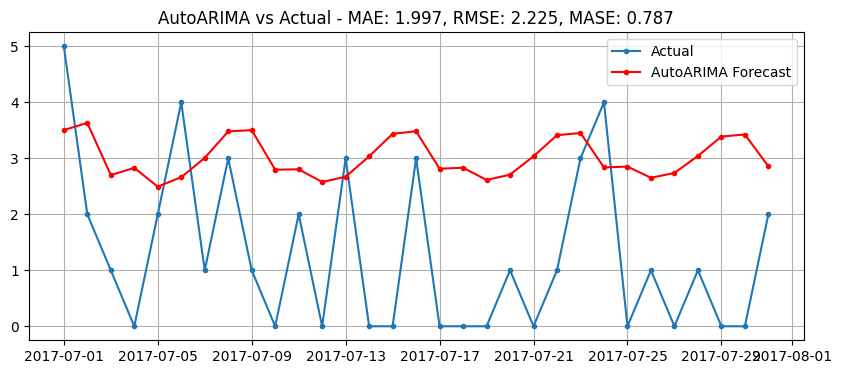

In [99]:
from statsforecast.models import AutoARIMA

auto_arima_model = AutoARIMA(
    max_p=3,
    max_d=1,
    max_q=3,
    max_P=1,
    max_D=1,
    max_Q=1,
    season_length=7,
    stepwise=True
)

key='AutoARIMA'
models = [auto_arima_model]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
    fallback_model=Naive()
)

h = len(ts_val)

y_pred = sf.forecast(
    df=_ts_train,
    h=h,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

results = _ts_val.merge(
    y_pred,
    on=['unique_id', 'ds'],
    how='left'
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = results['y'].values
y_hat = results[key].values

mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / scale

mase_value = mase(
    y_true,
    y_hat,
    ts_train['sales'].values,
    seasonality=7
)

print(f"MASE: {mase_value:.3f}")

plt.figure(figsize=(10, 4))

plt.plot(results['ds'], results['y'], '.-',label='Actual')
plt.plot(results['ds'], results[key],'.-', label=f'{key} Forecast', color='red')

plt.title(f'{key} vs Actual - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MASE: {mase_value:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### Thta model

MAE: 1.609
RMSE: 1.805
MASE: 0.634


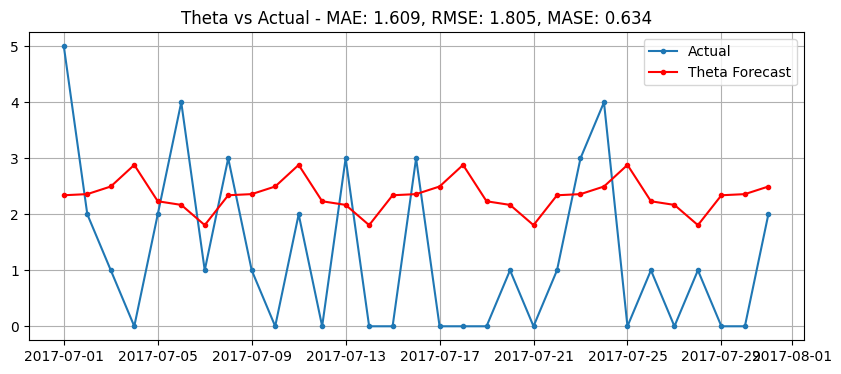

In [100]:
from statsforecast.models import Theta
model = Theta(season_length =7, decomposition_type = 'multiplicative' )

key='Theta'
models = [model]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
    fallback_model=Naive()
)

h = len(ts_val)

y_pred = sf.forecast(
    df=_ts_train,
    h=h,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

results = _ts_val.merge(
    y_pred,
    on=['unique_id', 'ds'],
    how='left'
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = results['y'].values
y_hat = results[key].values

mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / scale

mase_value = mase(
    y_true,
    y_hat,
    ts_train['sales'].values,
    seasonality=7
)

print(f"MASE: {mase_value:.3f}")

plt.figure(figsize=(10, 4))

plt.plot(results['ds'], results['y'], '.-',label='Actual')
plt.plot(results['ds'], results[key],'.-', label=f'{key} Forecast', color='red')

plt.title(f'{key} vs Actual - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MASE: {mase_value:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### TBATS

/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


MAE: 1.885
RMSE: 2.116
MASE: 0.743


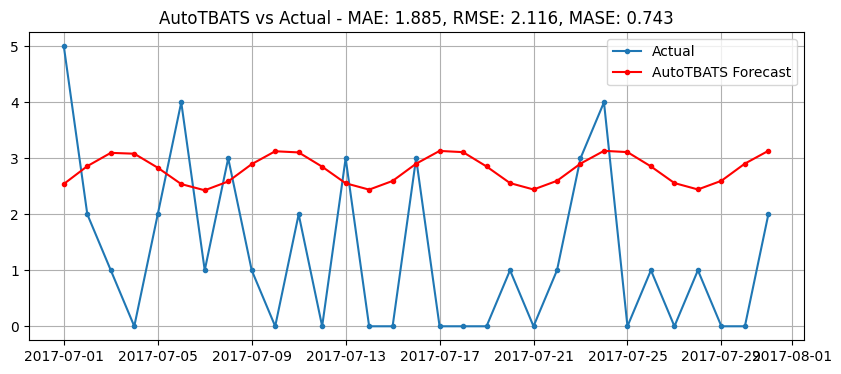

In [101]:
from statsforecast.models import AutoTBATS
model = AutoTBATS(season_length  = 7,
                     use_trend=True, use_damped_trend=True )

key='AutoTBATS'
models = [model]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
    fallback_model=Naive()
)

h = len(ts_val)

y_pred = sf.forecast(
    df=_ts_train,
    h=h,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

results = _ts_val.merge(
    y_pred,
    on=['unique_id', 'ds'],
    how='left'
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = results['y'].values
y_hat = results[key].values

mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / scale

mase_value = mase(
    y_true,
    y_hat,
    ts_train['sales'].values,
    seasonality=7
)

print(f"MASE: {mase_value:.3f}")

plt.figure(figsize=(10, 4))

plt.plot(results['ds'], results['y'], '.-',label='Actual')
plt.plot(results['ds'], results[key],'.-', label=f'{key} Forecast', color='red')

plt.title(f'{key} vs Actual - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MASE: {mase_value:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### Multiple Seasonal-Trend decomposition using LOESS (MSTL)

MAE: 1.876
RMSE: 2.154
MASE: 0.740


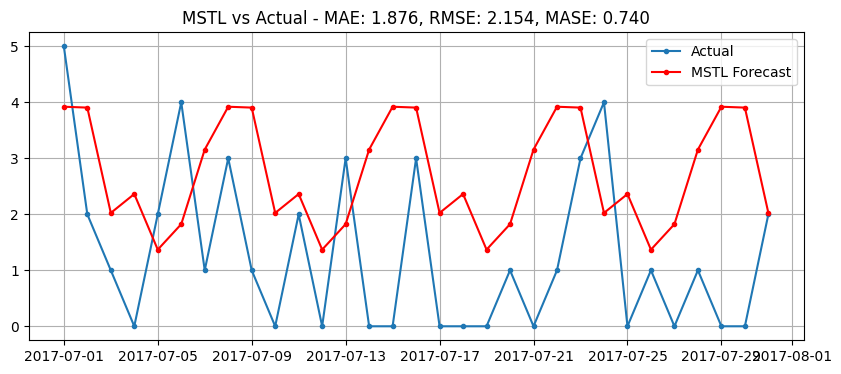

In [102]:
from statsforecast.models import MSTL
model = MSTL(season_length  = 7)

key='MSTL'
models = [model]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
    fallback_model=Naive()
)

h = len(ts_val)

y_pred = sf.forecast(
    df=_ts_train,
    h=h,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

results = _ts_val.merge(
    y_pred,
    on=['unique_id', 'ds'],
    how='left'
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = results['y'].values
y_hat = results[key].values

mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / scale

mase_value = mase(
    y_true,
    y_hat,
    ts_train['sales'].values,
    seasonality=7
)

print(f"MASE: {mase_value:.3f}")

plt.figure(figsize=(10, 4))

plt.plot(results['ds'], results['y'], '.-',label='Actual')
plt.plot(results['ds'], results[key],'.-', label=f'{key} Forecast', color='red')

plt.title(f'{key} vs Actual - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MASE: {mase_value:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### Run all models and build table

In [103]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def forecast_bias(y_true, y_pred):
    """
    Forecast Bias (%)
    Positive -> over-forecasting
    Negative -> under-forecasting
    """
    return 100.0 * (np.sum(y_pred) - np.sum(y_true)) / np.sum(y_true)

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_diff = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_diff))
    return np.mean(np.abs(y_true - y_pred)) / scale


from statsforecast import StatsForecast
from statsforecast.models import Naive
import time

def evaluate_model(
    model,
    model_name,
    ts_train,
    ts_val,
    _ts_train,
    _ts_val,
    freq='D',
    seasonality=7
):
    start = time.time()

    sf = StatsForecast(
        models=[model],
        freq=freq,
        n_jobs=-1,
        fallback_model=Naive()
    )

    h = len(ts_val)

    y_pred = sf.forecast(
        df=_ts_train,
        h=h,
        id_col='unique_id',
        time_col='ds',
        target_col='y'
    )

    results = _ts_val.merge(
        y_pred,
        on=['unique_id', 'ds'],
        how='left'
    )


    y_true = results['y'].values
    y_hat = results[model_name].values

    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mse = mean_squared_error(y_true, y_hat)
    mase_value = mase(
        y_true,
        y_hat,
        ts_train['sales'].values,
        seasonality=seasonality
    )
    fb = forecast_bias(y_true, y_hat)

    elapsed = time.time() - start

    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MASE': mase_value,
        'Forecast Bias (%)': fb,
        'Time Elapsed': elapsed
    }

from statsforecast.models import (
    Naive,
    SeasonalNaive,
    MSTL,
    Theta,
    AutoTBATS,
    AutoARIMA,
    HoltWinters,
    SimpleExponentialSmoothing,
    Holt,
    AutoETS

)

models_dict = {
    'Naive': Naive(),
    'SeasonalNaive': SeasonalNaive(season_length=7),
    'MSTL': MSTL(season_length=7),
    'Theta': Theta(season_length=7, decomposition_type='multiplicative'),
    'AutoTBATS': AutoTBATS(
        season_length=7,
        use_trend=True,
        use_damped_trend=True
    ),
    'AutoARIMA': AutoARIMA(
        max_p=3, max_d=1, max_q=3,
        max_P=1, max_D=1, max_Q=1,
        season_length=7,
        stepwise=True
    ),
    'HoltWinters': HoltWinters(
        error_type='A',
        season_length=7
    ),
    'SES': SimpleExponentialSmoothing(
        alpha=0.2
    ),
    'Holt': Holt(
        season_length=7
    ),
   
    'AutoETS': AutoETS(
        season_length=7,
        model='ZZZ',        # let ETS choose error/trend/seasonal
        damped=True
    )

}





In [104]:
results_list = []

for model_name, model in models_dict.items():
    print(f'Running {model_name}...')
    metrics = evaluate_model(
        model=model,
        model_name=model_name,
        ts_train=ts_train,
        ts_val=ts_val,
        _ts_train=_ts_train,
        _ts_val=_ts_val,
        freq='D',
        seasonality=7
    )
    results_list.append(metrics)

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.sort_values('MASE')
summary_df

Running Naive...
Running SeasonalNaive...
Running MSTL...
Running Theta...
Running AutoTBATS...


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


Running AutoARIMA...
Running HoltWinters...
Running SES...
Running Holt...
Running AutoETS...


,Model,MAE,MSE,RMSE,MASE,Forecast Bias (%),Time Elapsed
7,SES,1.574441,3.062022,1.749863,0.620719,76.917274,0.001953
3,Theta,1.608677,3.257953,1.804980,0.634216,80.823731,0.069181
1,SeasonalNaive,1.806452,4.838710,2.199707,0.712188,80.000000,0.002650
8,Holt,1.824528,4.174362,2.043126,0.719315,112.333415,0.023506
6,HoltWinters,1.851042,4.325428,2.079766,0.729768,116.816407,0.108938
9,AutoETS,1.851042,4.325428,2.079766,0.729768,116.816407,0.080523
2,MSTL,1.876316,4.640844,2.154262,0.739732,110.217060,0.022672
4,AutoTBATS,1.885187,4.478835,2.116326,0.743229,116.904024,0.338958
5,AutoARIMA,1.997274,4.952753,2.225478,0.787420,133.151423,3.355311
0,Naive,2.774194,9.419355,3.069097,1.093718,210.000000,0.003383


In [105]:
metrics

{'Model': 'AutoETS',
 'MAE': 1.8510416761833546,
 'MSE': 4.325428313765236,
 'RMSE': 2.0797664084615937,
 'MASE': 0.729767699747414,
 'Forecast Bias (%)': 116.8164066405437,
 'Time Elapsed': 0.08052301406860352}